In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir(r'/content/drive/My Drive/ECE1512')  # Change the directory to torchRay-master folder

# Requirements

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import cv2

# Dataset loader

In [4]:
train_dir = '/content/drive/My Drive/ECE1512/hmt_dataset/HMT_train' #you should change to your directory
test_dir = '/content/drive/My Drive/ECE1512/hmt_dataset/HMT_test' #you should change to your directory

train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=False)



Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


Overrided

# Create Model

In [5]:
weight_decay = 5e-4
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten?

#model.add(Flatten())
model.add(GlobalAveragePooling2D())
#model.add(Dense(1024, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
#                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(8, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                    

# Training

In [ ]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.SGD(),
              metrics=['accuracy'])

In [ ]:
def lr_scheduler(epoch):
    base_ep = 15
    return 1e-3 * (.5 ** (epoch // base_ep))
lr_reduce_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir='log2', write_graph=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, min_delta=0.)

In [7]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.n // 32,
                    epochs=150,
                    callbacks=[tensorboard_cb],                  
                    shuffle = True,
                    verbose=1)


In [ ]:
model.save('HMT.h5')

# Load Model

load saved trained model

In [7]:
model=load_model('/content/HMT.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                    

In [ ]:
def my_summary_iterator(path):
  for r in tf_record.tf_record_iterator(path):
    yield event_pb2.Event.FromString(r)
train_acc = []
train_loss = []
train_lr = []
# print('log/train/' + os.listdir('log/train')[2])
for e in my_summary_iterator('log2/train/' + os.listdir('log2/train')[-1]):
  for v in e.summary.value:
    if v.tag == 'epoch_accuracy':
      train_acc.append(v.simple_value)
    elif v.tag == 'epoch_loss':
      train_loss.append(v.simple_value)

In [9]:
plt.plot(np.arange(len(train_acc)), train_acc)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training progress: Accuracy')

In [10]:
plt.plot(np.arange(len(train_loss)), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training progress: Loss')

# Explanation

Load the explaier library

In [8]:
from xai_utils import *

Load a batch of images

In [9]:
test_generator.reset()

In [10]:
image_batch,label_batch=test_generator.next()

Classes:

In [11]:
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

Predict a single image

In [12]:
index=8

In [13]:
prediction=model(image_batch)
print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))

True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.96617067


# Task3: Biomedical image classification and interpretation 


In [14]:
##b. Overall classification accuracy on the test set. [0.25 Marks]
print("overall accuracy:")
loss, acc = model.evaluate_generator(test_generator)
# results = model.evaluate(dataset['x_test'], dataset['y_test'],verbose=2)
print(acc)

overall accuracy:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


0.8346773982048035


In [15]:
## c. Class-wise classification accuracy for all classes. [0.25 Marks]
from sklearn.metrics import classification_report

# y_pred = np.argmax(model(dataset['x_test']),axis=1)
prob = model.predict_generator(test_generator)
predlist = []
for p in prob:
  pred = np.argmax(p)
  predlist.append(pred)
y_pred = np.array(predlist)
print(classification_report(test_generator.classes, y_pred))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


              precision    recall  f1-score   support

           0       0.93      0.85      0.89        62
           1       0.61      0.76      0.68        62
           2       0.67      0.77      0.72        62
           3       0.93      0.85      0.89        62
           4       0.75      0.66      0.70        62
           5       0.94      0.82      0.88        62
           6       1.00      0.95      0.98        62
           7       0.95      1.00      0.98        62

    accuracy                           0.83       496
   macro avg       0.85      0.83      0.84       496
weighted avg       0.85      0.83      0.84       496



*ROC,AUC Code refer to Reference[1]*

*OneHotEncoder Code refer to Reference[2]*

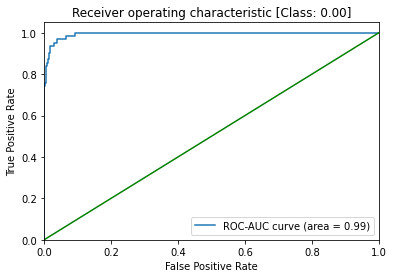

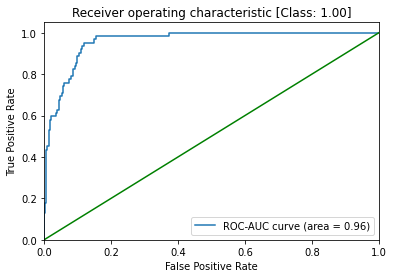

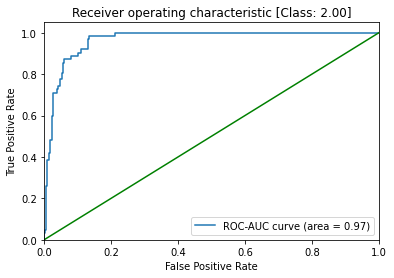

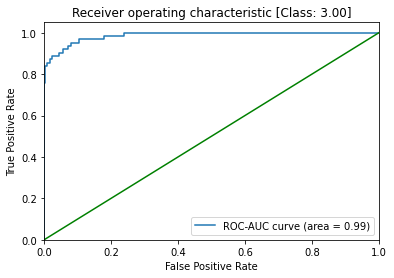

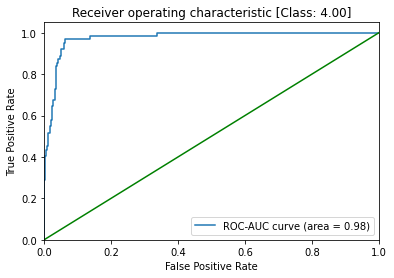

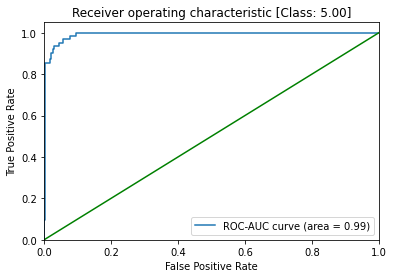

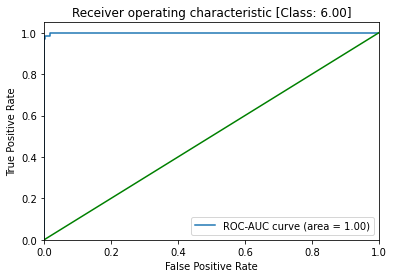

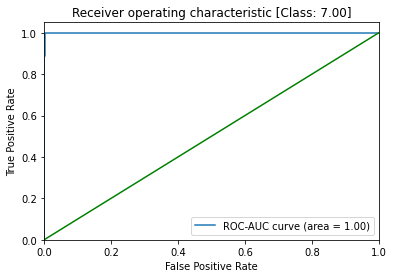

In [16]:
#d. Plot the classification ROC and AUC curves for each class.
plt.figure()

# one-hot encode the classes

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
yt = test_generator.classes
y_reshape= yt.reshape(-1, 1)
enc.fit(y_reshape)
enc.categories
y_re= enc.transform(y_reshape).toarray()
# prob = model(dataset['x_test'])
# y_sfit = model(dataset['x_test'])
y_sfit = prob
predict = np.argmax(prob, axis=1)
# make predictions (for roc/auc AND normalized confusion matrix)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_re[:, i], y_sfit[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    plt.plot(fpr[i], tpr[i], label="ROC-AUC curve (area = {1:0.2f})".format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], color="green")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic [Class: %0.2f]" % i)
    plt.legend(loc="lower right")
    plt.show()

*Confusion matrix Code refer to Reference[3]*

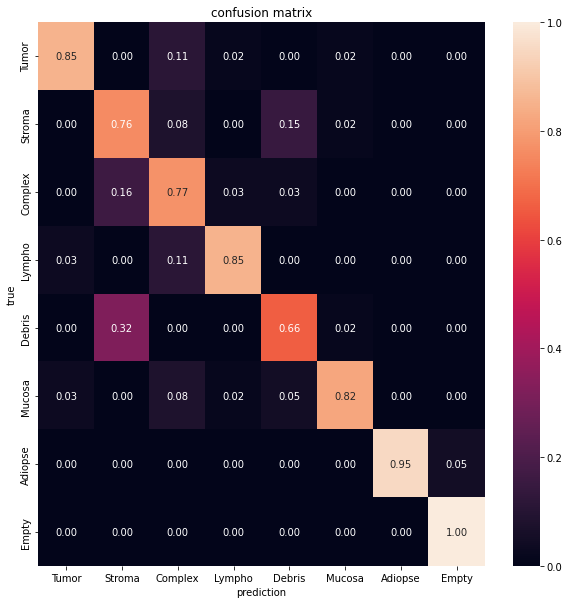

In [17]:
# e. Plot the normalized confusion matrix. [0.25 Marks]
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = metrics.confusion_matrix(yt, predict, normalize='true')
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes)
plt.ylabel('true')
plt.xlabel('prediction')
plt.title('confusion matrix')
plt.show(block=False)

In [18]:
# f. Precision, Recall, and F-1 score on the test set. [0.5 Marks]
from sklearn.metrics import precision_score, recall_score,f1_score
print("precision score is:", precision_score(yt, predict,average='micro'))
print("recall is:",recall_score(yt, predict,average='micro'))
print("f1_scrore is:", f1_score(yt, predict,average='micro'))


precision score is: 0.8346774193548387
recall is: 0.8346774193548387
f1_scrore is: 0.8346774193548387


Successful case:

This is a Successful example of the model because it has a very high confidence score and provides a correct prediction of the class.



In [19]:
#task3  question 4
#Show some examples of the success/failure cases of the model. 
#Among which two classes misclassification happens the most? Provide your insights and support your answers with analytic reasons. [1.25 Marks] 
input = np.expand_dims(np.expand_dims(image_batch[8], axis=0), axis=-1)
label = yt[8]
print('Correct : '+str(label))
print('Predicted : '+str(np.argmax(model(np.expand_dims(np.expand_dims(image_batch[8], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(image_batch[8], axis=0), axis=-1)).numpy()[0,label]))


Correct : 0
Predicted : 0
Confidence score for the correct label: 0.96617067


In [20]:
for i in range(image_batch.shape[0]):
  input = np.expand_dims(np.expand_dims(image_batch[i], axis=0), axis=-1)
  label = yt[i]
  if (model(np.expand_dims(np.expand_dims(image_batch[i], axis=0), axis=-1)).numpy()[0,label]) <0.5:
    print(i)
    print('Correct : '+str(label))
    print('Predicted : '+str(np.argmax(model(np.expand_dims(np.expand_dims(image_batch[i], axis=0), axis=-1)).numpy())))
    print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(image_batch[i], axis=0), axis=-1)).numpy()[0,label]))


4
Correct : 0
Predicted : 2
Confidence score for the correct label: 0.018222237
13
Correct : 0
Predicted : 3
Confidence score for the correct label: 0.4260302
15
Correct : 0
Predicted : 5
Confidence score for the correct label: 0.26126942
22
Correct : 0
Predicted : 2
Confidence score for the correct label: 0.15934676
29
Correct : 0
Predicted : 2
Confidence score for the correct label: 0.30764434


Failure case:

This is a failure example of the model because it has a very low confidence score and provides an incorrect prediction of the class.

In [21]:
input = np.expand_dims(np.expand_dims(image_batch[4], axis=0), axis=-1)
label = yt[4]
print('Correct : '+str(label))
print('Predicted : '+str(np.argmax(model(np.expand_dims(np.expand_dims(image_batch[4], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(image_batch[4], axis=0), axis=-1)).numpy()[0,label]))


Correct : 0
Predicted : 2
Confidence score for the correct label: 0.018222237


Two classes misclassification happen the most:

In [22]:
cm2=cm
mask = np.ones(cm2.shape, dtype=bool)
np.fill_diagonal(mask, 0)
mr = cm2[mask].max()
print('Based on the incorrect prediction list, we can see the two classes misclassification happen the most is Gourp 0 and Group 2')
print('The misclassification rate is :', mr )


Based on the incorrect prediction list, we can see the two classes misclassification happen the most is Gourp 0 and Group 2
The misclassification rate is : 0.3225806451612903


Generate explanation map

## SISE (Semantic Input Sampling for Explanation)

Set the layer(s)

In [23]:
layers=[['conv2d_3']]

In [24]:
%%time
explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
explanation_map_SISE -= explanation_map_SISE.min()
explanation_map_SISE /= explanation_map_SISE.max()+10e-30


CPU times: user 1.9 s, sys: 55.2 ms, total: 1.95 s
Wall time: 2.48 s


## Grad-CAM (Gradient-based Class Activation Mapping)

In [25]:
%%time
explanation_map_GradCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
explanation_map_GradCAM -= explanation_map_GradCAM.min()
explanation_map_GradCAM /= explanation_map_GradCAM.max()+10e-30

CPU times: user 157 ms, sys: 3.42 ms, total: 161 ms
Wall time: 166 ms


## RISE (Randomized Input Sampling for Explanation)

In [26]:
%%time
explanation_map_RISE = RISE(image_batch[index], model, class_index=np.argmax(prediction[index]) ,N_MASKS=1000)
explanation_map_RISE -= explanation_map_RISE.min()
explanation_map_RISE /= explanation_map_RISE.max()+10e-30

CPU times: user 4.57 s, sys: 658 ms, total: 5.23 s
Wall time: 4.97 s


## Plot the results

Text(0.5, 1.0, 'Explanation map (RISE)')

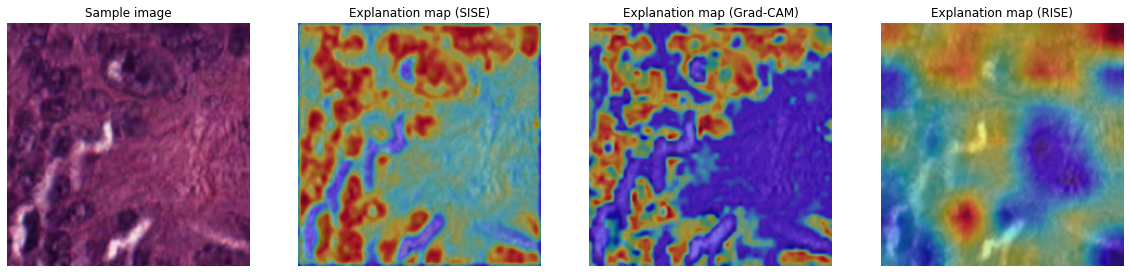

In [27]:
#@title Plot the results

plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.imshow(image_batch[index])
plt.axis('off')
plt.title('Sample image')

plt.subplot(1,4,2)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_SISE, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (SISE)')

plt.subplot(1,4,3)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_GradCAM, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Grad-CAM)')

plt.subplot(1,4,4)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_RISE, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (RISE)')

#SmoothGrad 
using callbacks.py, core.py, image.py, display.py, save.py

*Code refer to Reference[5]*


In [30]:
from smoothgrad import SmoothGradCallback

sgmodel = model
# callbacks = [
#     SmoothGradCallback(
#         validation_data=(image_batch[index], 224),
#         class_index=0,
#         num_samples=20,
#         noise=1.,
#         output_dir=('./logs8/smoothgrad'),
#     )
# ]

# sg= sgmodel.fit(image_batch[index], 224, batch_size=1, epochs=2, callbacks=callbacks)

callbacks = [
    SmoothGradCallback(
        validation_data=(image_batch),
        class_index=7,
        num_samples=10,
        noise=1.,
        output_dir=('./logs8/smoothgrad'),
    )
]
# image_batch,label_batch=test_generator.next()
valid = (image_batch,np.array(label_batch[index]))
sg= sgmodel.fit(valid, batch_size=5, epochs=2, callbacks=callbacks)

# np.expand_dims(image_batch[index], axis=0)

In [31]:
from core_smoothgrad44 import SmoothGrad

explanation = SmoothGrad()
sgmodel = model
# validation_data=dataset['x_test'], dataset['y_test']

gridSmoothGrad = explanation.explain(np.expand_dims(image_batch[index], axis=0), sgmodel, class_index=10, num_samples=20, noise=0.5)


Text(0.5, 1.0, 'Explanation map (SISE)')

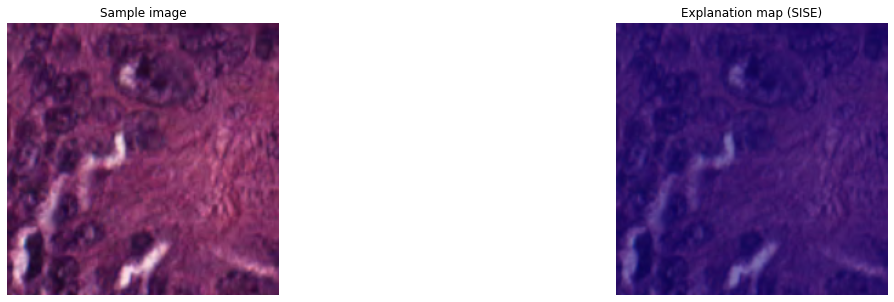

In [34]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.imshow(image_batch[index])
plt.axis('off')
plt.title('Sample image')

plt.subplot(1,2,2)
plt.imshow(map, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (SmoothGrad)')


#IntegratedGrad
using support .py files

*Code refer to Reference[6]*


In [35]:
from integrated_gradients import *

# Initialize IntegratedGradients instance
n_steps = 50
method = "gausslegendre"
ig  = IntegratedGradients(model,
                          n_steps=n_steps, 
                          method=method)

# Calculate attributions for the first 10 images in the test set
nb_samples = 10
X_test_sample = image_batch[:nb_samples]
predictions = model(X_test_sample).numpy().argmax(axis=1)
explanation = ig.explain(X_test_sample, 
                         baselines=None, 
                         target=predictions)
# Metadata from the explanation object
explanation.meta

{'explanations': ['local'],
 'name': 'IntegratedGradients',
 'params': {'internal_batch_size': 100,
  'layer': 0,
  'method': 'gausslegendre',
  'n_steps': 50,
  'target_fn': None},
 'type': ['whitebox'],
 'version': '0.6.5dev'}

In [36]:
explanation['X'].shape
explanation['X'][1].shape
x = explanation['X'][1]
map = x[:, :, 0]
print(map.shape)

(224, 224)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Explanation map (Grad-CAM)')

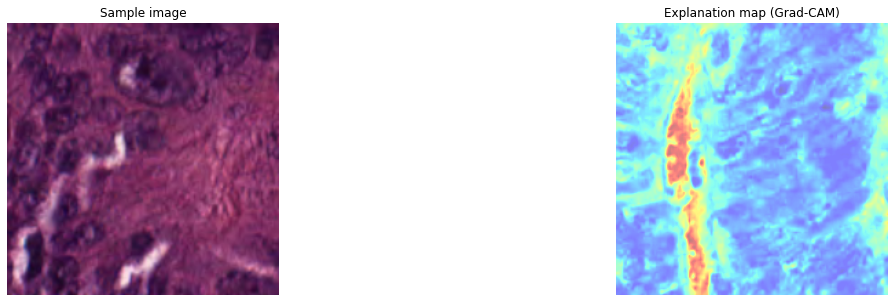

In [37]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.imshow(image_batch[index])
plt.axis('off')
plt.title('Sample image')

plt.subplot(1,2,2)
plt.imshow(map, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Grad-CAM)')



# Task4: Quantitative evaluation of the attribution methods

## Quantitative evaluation of the explanation algorithm

In [38]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

SISE Drop/Inc rate:

In [42]:
test_generator.reset()
drop_rate = 0.
inc_rate = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
        drop_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_SISE, class_index=np.argmax(prediction[index]), frac=0.9)[0]
        inc_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_SISE, class_index=np.argmax(prediction[index]), frac=0.9)[1]

drop_rate /= (15*32)
inc_rate /= (15*32)


In [43]:
print('drop rate is:', drop_rate)
print('increase rate is:', inc_rate)

drop rate is: 0.5977329593438689
increase rate is: 0.17916666666666667


SmoothGrad Drop/Inc rate:

In [44]:
drop_rate2 = 0.
inc_rate2 = 0.
for _ in range(5):
    image_batch,label_batch=test_generator.next()
    for index in range(10):
        explanation = SmoothGrad()
        validation_data=image_batch[index], yt[index]
        explanation_map = explanation.explain(validation_data, sgmodel, class_index=0, num_samples=20, noise=1)

        # prediction=model(image_batch)
        # explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
        drop_rate2 += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map, class_index=np.argmax(prediction[index]), frac=0.9)[0]
        inc_rate2 += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map, class_index=np.argmax(prediction[index]), frac=0.9)[1]
drop_rate2 /= (15*32)
inc_rate2 /= (15*32)


In [52]:
print('drop rate is:', drop_rate2)
print('increase rate is:', inc_rate2)

drop rate is: 0.6093889108384625
increase rate is: 0.4113764379208345


IntegratedGrad Drop/Inc rate:

In [53]:
drop_rate3 = 0.
inc_rate3 = 0.
for _ in range(5):
    image_batch,label_batch=test_generator.next()
    for index in range(10):
        X_test_sample = image_batch[:nb_samples]
        prediction = model(X_test_sample).numpy().argmax(axis=1)
        explanation = ig.explain(X_test_sample,baselines=None,target=predictions)
        explanation_map = explanation['X']
        # prediction=model(image_batch)
        # explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
        drop_rate2 += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map, class_index=np.argmax(prediction[index]), frac=0.9)[0]
        inc_rate2 += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map, class_index=np.argmax(prediction[index]), frac=0.9)[1]
drop_rate3 /= (15*32)
inc_rate3 /= (15*32)

In [55]:
print('drop rate is:', drop_rate3)
print('increase rate is:', inc_rate3)

drop rate is: 0.9347329974487091
increase rate is: 0.2732646750980823


# Reference

[1] Task 3-Question 3.d, rocauc:
https://stackoverflow.com/questions/33547965/computing-auc-and-roc-curve-from-multi-class-data-in-scikit-learn-sklearn

[2] Task 3-Question 3.d, onehotencoder:
https://docs.w3cub.com/scikit_learn/modules/generated/sklearn.preprocessing.onehotencoder

[3] Task 3-Question 3.e, confusion matrix:
https://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix

[4] Task 2-Model 1, smoothgrad: 
https://docs.seldon.io/projects/alibi/en/latest/examples/integrated_gradients_mnist.html

[5] Task 2-Model 2, IntegratedGrad: 
https://github.com/sicara/tf-explain

